<a href="https://colab.research.google.com/github/enriqueasegura/Quantum-X/blob/master/QC_Task_VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!pip install git+https://github.com/quantumlib/Cirq
  
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq
from cirq.ops import CNOT, TOFFOLI
from cirq import Simulator
import random
from sympy import Symbol
from cirq.circuits import InsertStrategy


! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

import matplotlib

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf


  Cloning https://github.com/quantumlib/Cirq to /tmp/pip-req-build-8rtp8lee
  Running command git clone -q https://github.com/quantumlib/Cirq /tmp/pip-req-build-8rtp8lee
  Created wheel for cirq: filename=cirq-0.8.0.dev0-cp36-none-any.whl size=1295555 sha256=9b04093aac798e0be661abd6733e25c6b06e000f0893cb0fbbfa2b7f2fbae63d
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_j7u07n/wheels/c9/f4/ee/029123a49c5e2d75d08c2a9f937e207b88f045901db04632a7
Successfully built cirq
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-

#Find the lowest eigenvalue of the following matrix

$\begin{equation*}
H = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 1& 0 \\
0 & 1 & -1& 0 \\\
0 & 0 & 0 & 0 
\end{pmatrix}
\end{equation*}
$

using VQE-like circuits, handwritten by yourself.

In general this exercise might be pretty difficult, so below there are a couple of tips. I’ve written them in pale font, so that those of you who embrace the challenge don’t look at them accidentally ;) 
1. It requires decomposing the matrix to sum of Pauli terms. 
2. Decomposition involves only terms consisting of the same matrices, i.e.: II, XX, YY, ZZ and the coefficients are +/- 2.
3. The ansatz you can use is: (IX) CX (RZ I) (HI) |00>, where angle in RZ is your variational parameter.
4. You can find explanation of VQE in this [blogpost](https://www.mustythoughts.com/post/variational-quantum-eigensolver-explained), You can also find links to further resources there.
5. You can just search through all angles for RZ, you don’t need to use any optimizers like gradient descent.



##Borrowed Code to Decompose Two-Qubit Matrix

In [0]:
#borrowed from Michael H. Goerz

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    #modified from his original xrange because it was not working
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (c2s(a_ij), label))

In [0]:
h_initial = np.matrix([[0,0,0,0], 
                      [0, -1, 1, 0], 
                      [0,1,-1,0], 
                      [0,0,0,0]])

In [4]:
#the actual answer from what we know

min_eigenvalue = np.min(np.linalg.eigvals(h_initial))

print('Minimum eigenvalue in this matrix (the answer we need to get): ', min_eigenvalue)

Minimum eigenvalue in this matrix (the answer we need to get):  -2.0


#Decomposition of Matrix:

In [5]:
h_decomposed = decompose(h_initial)

-0.5	*	( I \otimes I )
0.5	*	( sigma_x \otimes sigma_x )
0.5	*	( sigma_y \otimes sigma_y )
0.5	*	( sigma_z \otimes sigma_z )


Thus we can write the following equation: 

\begin{eqnarray}
H &=& \frac{-1}{2} I_1 \otimes I_2 + \frac{1}{2} X_1 \otimes X_2 + \frac{1}{2} Y_1 \otimes Y_2 + \frac{1}{2} Z_1 \otimes Z_2
\end{eqnarray}

This represents the decomposition of the hamiltonian of interest for this task. Each tensor product - minus the first term - will be implemented as a quantum circuit below. 


### Code to Develop Quantum Circuits to Represent Decomposition:

In [0]:
def ansatz(th, input_q):
  rot= cirq.YPowGate(exponent=th)
  yield rot(input_q)

def XX_circuit(th1, th2, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #first rotation
  rot1= cirq.YPowGate(exponent=th1)
  yield rot1(q[0])
  yield rot1(q[1])

  #second rotation Y since it's an X 
  rot2 = cirq.YPowGate(exponent=th2)
  yield rot2(q[0])
  yield rot2(q[1])

  yield cirq.measure(*q)
  return c

def YY_circuit(th1, th2, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #first rotation
  rot1= cirq.YPowGate(exponent=th1)
  yield rot1(q[0])
  yield rot1(q[1])

  #second rotation X since it's an Y
  rot2 = cirq.XPowGate(exponent=th2)
  yield rot2(q[0])
  yield rot2(q[1])

  yield cirq.measure(*q)
  return c

def ZZ_circuit(th1, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #first rotation
  rot1= cirq.YPowGate(exponent=th1)
  yield rot1(q[0])
  yield rot1(q[1])

  yield cirq.measure(*q)
  return c



## Function Wrapper

In [0]:
def VQE_Circuit(th1, th2, th3, th4, th5,num_q):
  #the circuits for each hamiltonian
  #not to be confused with the quantum gates!!!!!
  cXX = cirq.Circuit()
  cYY = cirq.Circuit()
  cZZ = cirq.Circuit()

  #develop the circuits to represent the hamiltonian
  cXX.append(XX_circuit(th1,th2, num_q))
  cYY.append(XX_circuit(th3,th4, num_q))
  cZZ.append(ZZ_circuit(th5, num_q))

  return(cXX, cYY, cZZ)

#Gradient Descent on Optimization Code

Last year, and the first introduction to quantum computing I had, was through Farhi et al's paper on quantum neural networks for state classification. 

I borrow their implementation of Gradient Descent specifically for this VQE optimization of the circuits. 

It is worth saying that it matters a great deal the seed values each gate on the quantum circuit representing the ansatz.

## Note on Implementation of Gradient Descent

This is standard version of stochastic gradient descent. At the moment of writing, I am not sure how to deploy ADAM or other optimized version of the algorithm given that the loss function is defined for each parameter that is optimized.

In the future, it would be advantageous to fit ADAM on this circuit to further enhance VQE algorithm.

In [0]:
def VQE_Optimization(th1, th2, th3, th4, th5,num_q, num_reps):
  
  #get the holders of the actual data 
  
  angle_rot1_XX = []
  angle_rot2_XX = []

  angle_rot1_YY = []
  angle_rot2_YY = []

  angle_rot1_ZZ = []

  energy = []
  
  #keep the loss for gradient descent

  gradient_momentXX = 0 
  momentum_momentXX = 0

  gradient_momentYY = 0 
  momentum_momentYY = 0

  gradient_momentZZ = 0 
  momentum_momentZZ = 0
  beta_1 = 0.9
  beta_2 = 0.999
  smoothing_epsilon = 1e-8
  learning_rate = 0.005
  
  loss_XX = []
  loss_YY = []
  loss_ZZ = [] 

  delta_energy =[]

  grad_square = []
  
  count = 0 

  coef1, coef2, coef3, coef4 = -0.5, 0.5, 0.5, 0.5

  status = 'not done'

  #get the seed values of what it should be
  energy.append(0)

  while count < 2000:
    
    #seed values:
    angle_rot1_XX.append(th1)
    angle_rot2_XX.append(th2)

    angle_rot1_YY.append(th3)
    angle_rot2_YY.append(th4)
    
    angle_rot1_ZZ.append(th5)

    #call the circuit function to make the circuits 
    current_VQE = VQE_Circuit(th1, th2, th3, th4, th5, num_q)

    curr_simulator_XX = cirq.Simulator()
    curr_simulator_YY = cirq.Simulator()
    curr_simulator_ZZ = cirq.Simulator()
    
    results_XX = curr_simulator_XX.run(current_VQE[0], repetitions=num_reps)
    results_YY = curr_simulator_YY.run(current_VQE[1], repetitions=num_reps)
    results_ZZ = curr_simulator_ZZ.run(current_VQE[2], repetitions=num_reps)
    
    
    s_kXX, s_vXX= zip(*results_XX.measurements.items())
    s_kYY, s_vYY= zip(*results_YY.measurements.items())
    s_kZZ, s_vZZ= zip(*results_ZZ.measurements.items())
    
    curr_state_values_XX = 1 - 2*np.array(s_vXX).astype(np.int32)
    curr_state_values_YY = 1 - 2*np.array(s_vYY).astype(np.int32)
    curr_state_values_ZZ = 1 - 2*np.array(s_vZZ).astype(np.int32)

    curr_predicted_label_value_XX = np.mean(curr_state_values_XX)
    curr_predicted_label_value_YY = np.mean(curr_state_values_YY)
    curr_predicted_label_value_ZZ = np.mean(curr_state_values_ZZ)

    current_loss_value_XX = 1 - np.square(curr_predicted_label_value_XX)
    current_loss_value_YY = 1 - np.square(curr_predicted_label_value_YY)
    current_loss_value_ZZ = 1 - np.square(curr_predicted_label_value_ZZ)

    loss_XX.append(current_loss_value_XX)
    loss_YY.append(current_loss_value_YY)
    loss_ZZ.append(current_loss_value_ZZ)
    
    current_gradient_value_XX = 2*curr_predicted_label_value_XX
    current_gradient_value_YY = 2*curr_predicted_label_value_YY
    current_gradient_value_ZZ = 2*curr_predicted_label_value_ZZ
    
    current_grad_square_XX = np.square(current_gradient_value_XX)
    current_grad_square_YY = np.square(current_gradient_value_YY)
    current_grad_square_ZZ = np.square(current_gradient_value_ZZ)

    avg_grad_square = (current_grad_square_XX +  current_grad_square_YY +  current_grad_square_ZZ)/3
    
    """
    Decomposition of Hamiltonian:

    -0.5	*	( I \otimes I )
    0.5	*	( sigma_x \otimes sigma_x )
    0.5	*	( sigma_y \otimes sigma_y )
    0.5	*	( sigma_z \otimes sigma_z )
    """
    #laying down the energy expectation terms
    term1 = coef1*1
    term2 = coef2*curr_predicted_label_value_XX
    term3 = coef3*curr_predicted_label_value_YY
    term4 = coef4*curr_predicted_label_value_ZZ
    
    curr_energy = term1 + term2 + term3 + term4

    #keep energy 
    energy.append(curr_energy)

    energy_diff = energy[count] - energy[count-1]
    delta_energy.append(energy_diff)

    #now do the SGD
    #print('current count: ', count)
    #print('current loss:', [current_loss_value_XX, current_loss_value_YY, current_loss_value_ZZ])
    #print('current params:', [th1, th2, th3, th4, th5])
    print('current count: ', count,'current energy:', curr_energy)

    if np.absolute(current_loss_value_XX) < 1e-4 and np.absolute(current_loss_value_YY) < 1e-4 and np.absolute(current_loss_value_ZZ) < 1e-4:
    #elif np.absolute(target_difference) < 1e-3:
      status = 'done'
      print('Done! Final Weight: ',angle_rot1_XX[-1],angle_rot2_XX[-1],angle_rot1_YY[-1],angle_rot2_YY[-1], angle_rot1_ZZ[-1])
      #cirq.plot_state_histogram(test_results)   
      break
    
    else:

      th1 = th1 - learning_rate * current_loss_value_XX/current_gradient_value_XX
      th2 = th2 - learning_rate * current_loss_value_XX/current_gradient_value_XX

      th3 = th3 - learning_rate * current_loss_value_YY/current_gradient_value_YY
      th4 = th4 - learning_rate * current_loss_value_YY/current_gradient_value_YY

      th5 = th5 - learning_rate * current_loss_value_ZZ/current_gradient_value_ZZ

      count+=1

  return(angle_rot1_XX, angle_rot2_XX, angle_rot1_YY,angle_rot2_YY,angle_rot1_ZZ, energy, loss_XX, loss_YY, loss_ZZ, delta_energy)

## Testing VQE to Find Eigenvalue

Below you will find the values used using the blogs linked on the Google doc. 

For the future: important to work out the optimal repetition.

In [0]:
# Arbitrary value of theta
th1 = np.pi
th2 = -np.pi/2

th3 = np.pi
th4 = np.pi/2

th5 = 1 #I adjusted this value to avoid plateaus from the tutorial.

num_q = 2

num_reps = 1000

In [30]:
test_optimization = VQE_Optimization(th1, th2, th3, th4, th5, num_q, num_reps)

current count:  0 current energy: -1.2165
current count:  1 current energy: -1.234
current count:  2 current energy: -1.309
current count:  3 current energy: -1.72
current count:  4 current energy: -1.71
current count:  5 current energy: -1.7469999999999999
current count:  6 current energy: -1.7165000000000001
current count:  7 current energy: -1.7415
current count:  8 current energy: -1.734
current count:  9 current energy: -1.7454999999999998
current count:  10 current energy: -1.7625000000000002
current count:  11 current energy: -1.7385
current count:  12 current energy: -1.724
current count:  13 current energy: -1.7429999999999999
current count:  14 current energy: -1.763
current count:  15 current energy: -1.7345
current count:  16 current energy: -1.7505
current count:  17 current energy: -1.716
current count:  18 current energy: -1.744
current count:  19 current energy: -1.7365
current count:  20 current energy: -1.7255
current count:  21 current energy: -1.716
current count:  

# Resulting Eigenvalue 

In [0]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

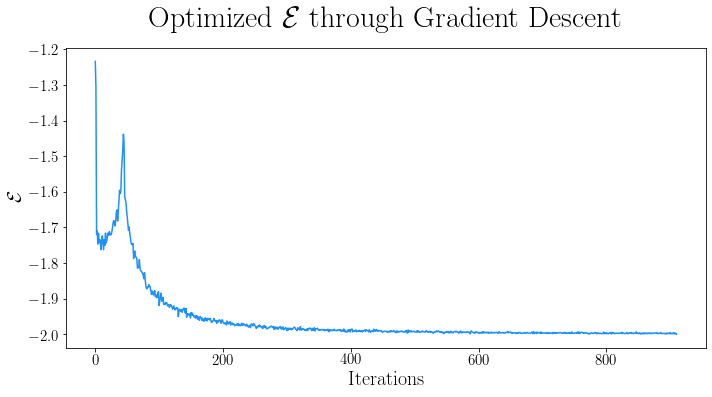

In [94]:
plt.figure(figsize=(10,7))

plt.plot(test_optimization[5][2:], linestyle='-', color='dodgerblue')
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r'$\mathcal{E}$', fontsize=20)
plt.title(r'Optimized $\mathcal{E}$ through Gradient Descent', fontsize=30)

plt.tight_layout()

plt.subplots_adjust(top=0.7)

#Resulting Circuits that Comprise Hamiltonian

In [95]:
#resultant circuits

op_c = VQE_Circuit(test_optimization[0][-1],test_optimization[1][-1], test_optimization[2][-1],
                   test_optimization[3][-1],test_optimization[4][-1], num_q)
print('XX Circuit:')
print(op_c[0])
print('*******')
print('YY Circuit:')
print(op_c[1])
print('*******')
print('ZZ Circuit:')
print(op_c[2])

XX Circuit:
0: ───Y^0.845───Y^(2/15)───M───
                           │
1: ───Y^0.845───Y^(2/15)───M───
*******
YY Circuit:
0: ───Y^-0.725───Y^-0.295───M───
                            │
1: ───Y^-0.725───Y^-0.295───M───
*******
ZZ Circuit:
0: ───Y───M───
          │
1: ───Y───M───


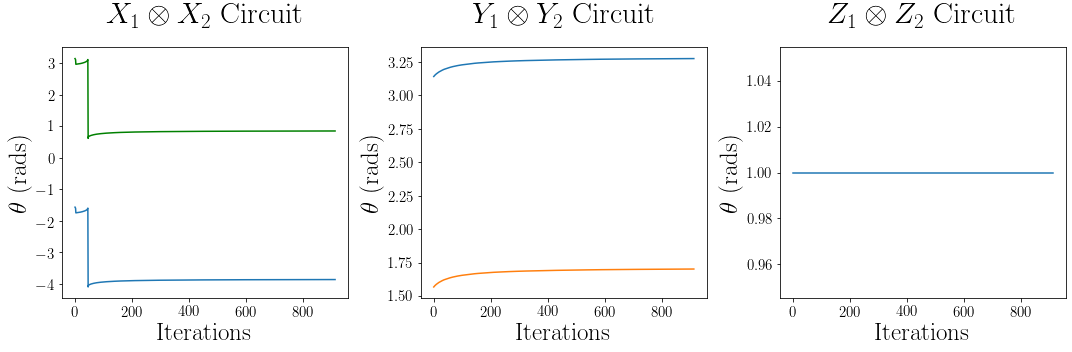

In [101]:
plt.figure(figsize=(15,5))

plt.subplot(131)

plt.plot(test_optimization[0], color='green')
plt.plot(test_optimization[1])
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\theta$ (rads)', fontsize=25)

plt.title(r'$X_1 \otimes X_2$ Circuit', fontsize=30)

plt.subplot(132)

plt.plot(test_optimization[2])
plt.plot(test_optimization[3])
plt.tick_params(axis='both', labelsize=15)

plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\theta$ (rads)', fontsize=25)

plt.title(r'$Y_1 \otimes Y_2$ Circuit', fontsize=30)

plt.subplot(133)

plt.title(r'$Z_1 \otimes Z_2$ Circuit', fontsize=30)
plt.plot(test_optimization[4])
plt.tick_params(axis='both', labelsize=15)

plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\theta$ (rads)', fontsize=25)

plt.tight_layout()

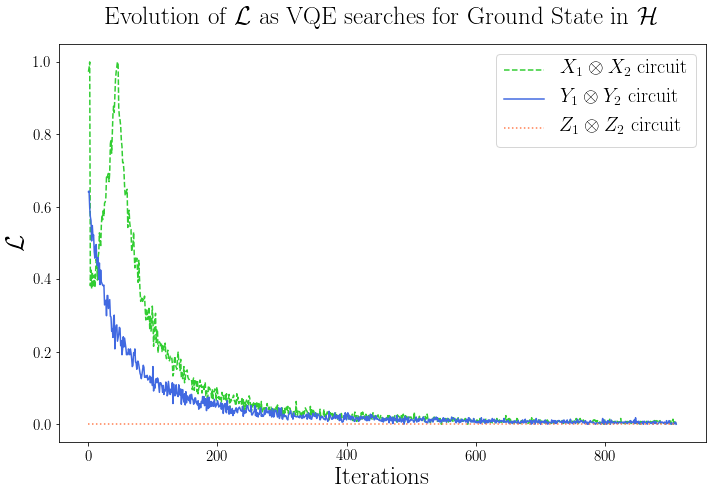

In [110]:
plt.figure(figsize=(10,7))

plt.plot(test_optimization[6], label=r'$X_1 \otimes X_2$ circuit', color='limegreen', linestyle='--')
plt.plot(test_optimization[7], label=r'$Y_1 \otimes Y_2$ circuit', color='royalblue', linestyle='-')
plt.plot(test_optimization[8], label=r'$Z_1 \otimes Z_2$ circuit', color='coral', linestyle=':')

plt.legend(loc='best', fontsize=20)

plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=25)
plt.ylabel(r'$\mathcal{L}$',fontsize=25)

plt.title(r'Evolution of $\mathcal{L}$ as VQE searches for Ground State in $\mathcal{H}$', fontsize=25)

plt.tight_layout()